In [1]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from helpers import *

## Example Notebook (How to use get_nearest_point_by_road())

The get_nearest_point_by_road() takes in 2 sets of points (aq_points and congestion_points) alongside a road network, and returns a list where each item is an air quality point with it's nearest congestion point data attached. This notebook demonstrates how to use this function.

#### Change the data paths below to where you have the data stored

In [2]:
# DATA PATHS
AIR_QUALITY_POINTS_PATH = os.path.join('Data', 'AirQuality', 'NO2_site_metadata_20180901_20201130.csv')
CONGESTION_POINTS_PATH = os.path.join('Data', 'CongestionScoot', 'congestion_location.csv')

ROADS_PATH = os.path.join('Data', 'JoinTest', 'camden_roads.geojson')

LONDON_BOROUGHS_PATH = os.path.join('Data', 'JoinTest', 'stats_boundaries_london', 'ESRI', 'London_Borough_Excluding_MHW.shp')

#### I am currently using the no2 data as an example, but you can use any other point data

In [3]:
# Load no2_points (currently in csv with lat and lon, convert to geopandas)
no2_points = gpd.read_file(AIR_QUALITY_POINTS_PATH)
no2_points['geometry'] = gpd.points_from_xy(no2_points.Longitude, no2_points.Latitude)
no2_points.crs = 'EPSG:4326'

# Reproject no2_points to BNG
no2_points = no2_points.to_crs('EPSG:27700')

#### Congestion data below is just the locations of where the congestion points are.
We'll have to add in the hourly data before/after this function is called.

In [4]:
# Load congestion_data (currently in csv with easting and northing, convert to geopandas)
congestion_data = gpd.read_file(CONGESTION_POINTS_PATH)
congestion_data['geometry'] = gpd.points_from_xy(congestion_data.Easting, congestion_data.orthing)

# Set current CRS to British National Grid
congestion_data.crs = 'EPSG:27700'

#### Using Camden as an example subset (the whole of London might take a bit of time)

In [5]:
# Load London Borough Boundaries
london_Borough = gpd.read_file(LONDON_BOROUGHS_PATH)
london_Borough.crs = 'EPSG:27700'

In [6]:
# Extract Camden Borough
camden_shape = london_Borough[london_Borough['NAME'] == 'Camden']

In [7]:
# Get subsets of data for Camden Borough
no2_camden = gpd.sjoin(no2_points, camden_shape, op='within')
congestion_camden = gpd.sjoin(congestion_data, camden_shape, op='within')

C:\Users\juane\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\juane\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


##### Road location data was scraped from OpenStreetMap using Overpass Turbo

In [8]:
# Load Camden roads geojson
camden_roads = gpd.read_file(ROADS_PATH)

# Remove all point data in camden_roads
camden_roads = camden_roads[camden_roads['geometry'].geom_type == 'LineString']

camden_roads.crs = 'EPSG:4326'
camden_roads = camden_roads.to_crs('EPSG:27700')

camden_roads = camden_roads.dissolve(by='name')

### Plot example data

As you can see, I don't have all the roads locations, so some points are lost in the middle of nowhere.

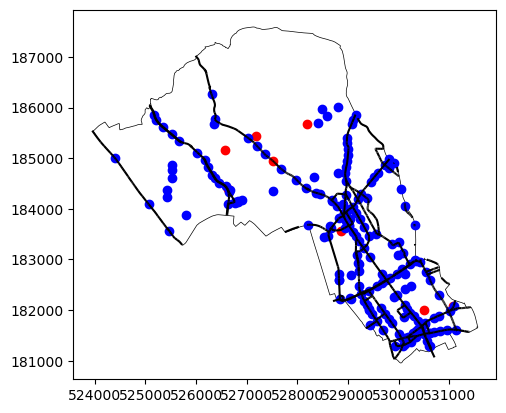

In [9]:
# Plot Camden data
fig, ax = plt.subplots()
camden_shape.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
no2_camden.plot(ax=ax, color='red')
congestion_camden.plot(ax=ax, color='blue')
camden_roads.plot(ax=ax, color='black')
plt.show()

# THE FUNCTION

As you can see, the function has 3 main parameters:

1. Road network data
2. Air quality points
3. Congestion points

There are also 2 more optional parameters:

<b>buffer_distance</b>: The farthest distance away from the road that the function will look for the air quality and congestion points. If the air quality point is further than this distance from any road, it will not be included in the final list.

<b>max_distance_between_points</b>: The farthest distance away from the air quality point that the function will look for the nearest congestion point.

The function then returns a list of geodataframes. Each geodataframe has the air quality geometry point data (alongside the rest of the air quality data), BUT with the nearest congestion point data attached to it.

As a handy extra, the function also shows a loading bar to show how far along the process is (alongside an estimated time till completion).

In [12]:
results = get_nearest_point_by_road(camden_roads, no2_camden, congestion_camden)

90it [00:00, 116.58it/s]


### Example plot

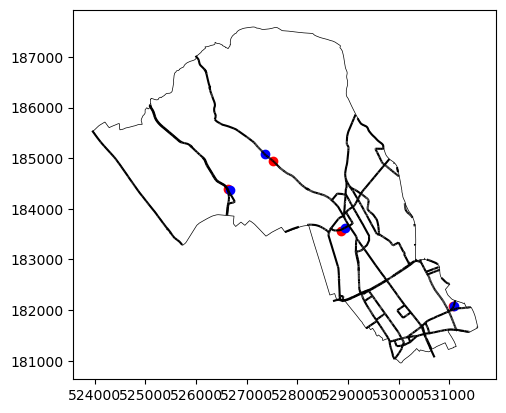

In [15]:
# Plot the pairs of points
fig, ax = plt.subplots()
camden_shape.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
camden_roads.plot(ax=ax, color='black')
for result in results:
    result_air = gpd.GeoDataFrame(result, geometry='geometry')

    result_con = gpd.GeoDataFrame(result)

    result_con['geometry'] = gpd.points_from_xy(result.Easting, result.orthing)


    result_air.plot(ax=ax, color='red', marker='o')
    result_con.plot(ax=ax, color='blue', marker='o')
plt.show()
